## Setup

Import the necessary modules:

In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-21 13:13:45.532333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and reshape dataset

In [3]:
from lib_util import utils
from sklearn.model_selection import train_test_split

config = utils.get_config('transformer_exp')

melspec_data = utils.load_sliced_numpy_array('preprocessed_data')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
mel_val, mel_test, lab_val, lab_test             = train_test_split(mel_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

# read in the config
pp_config = utils.get_config('preprocess')

def normalization(mel_train, mel_test, mel_val):
    """Normalize the data files by dividing every data point by the maximum of the train data set
    """
    maximum = np.amax(mel_train)
    mel_train = mel_train/maximum
    mel_test = mel_test/maximum
    mel_val = mel_val/maximum
    return (mel_train.astype(np.float32), mel_test.astype(np.float32), mel_val.astype(np.float32))

mel_train, mel_test, mel_val = normalization(mel_train, mel_test, mel_val)

#n_mels = pp_config['melspectogram']['n_mels']
mel_train = mel_train.reshape(mel_train.shape[0], 48000, -1)
mel_val   = mel_val.reshape(mel_val.shape[0], 48000, -1)
mel_test   = mel_test.reshape(mel_test.shape[0], 48000, -1)

print("training shape:", mel_train.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((mel_train, lab_train))
val_dataset = tf.data.Dataset.from_tensor_slices((mel_val, lab_val))
test_dataset = tf.data.Dataset.from_tensor_slices((mel_test, lab_test))

Load slice from file preprocessed_data_001.npy
Load slice from file preprocessed_data_002.npy
Load slice from file preprocessed_data_003.npy
Load slice from file preprocessed_data_004.npy
Load slice from file preprocessed_data_005.npy
Load slice from file preprocessed_data_006.npy
Load slice from file preprocessed_data_007.npy
Load slice from file preprocessed_data_008.npy
Load slice from file preprocessed_data_009.npy
Loaded 9 files as slices, resulting shape: (4068, 48000)
training shape: (2440, 48000, 1)


2023-01-21 13:13:54.894583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

### Set up a data pipeline with `tf.data`

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [4]:
BUFFER_SIZE = 20000
BATCH_SIZE = 256

In [5]:
def make_batches(ds):
  return (
      ds
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [6]:
# Create training and validation set batches.
train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)
test_batches = make_batches(test_dataset)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Protugese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

## Define the components

In [8]:
class FeatureExtractor:
    def __init__(self) -> None:
        self.conv_layers = [
            tf.keras.layers.Conv1D(8, 8, 3, padding='same', activation='gelu', data_format='channels_last'),
            tf.keras.layers.Conv1D(16, 4, 3, padding='same', activation='gelu', data_format='channels_last'),
            tf.keras.layers.Conv1D(64, 4, 3, padding='same', activation='gelu', data_format='channels_last'),
            tf.keras.layers.Conv1D(128, 3, 2, padding='same', activation='gelu', data_format='channels_last'),
            tf.keras.layers.Conv1D(256, 3, 2, padding='same', activation='gelu', data_format='channels_last')
        ]

        self.max_pooling = tf.keras.layers.MaxPool2D((2, 2))

        self.normalization = tf.keras.layers.LayerNormalization()

    def __call__(self, x):
        for convolution in self.conv_layers:
            x = convolution(x)

        return self.normalization(x)


feature_extractor = FeatureExtractor()
for e in train_batches.as_numpy_iterator():
  x = e
  break

x = feature_extractor(x[0])

print(x.shape)

(256, 445, 256)


In [9]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def call(self, x):
    length = tf.shape(x)[1]
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x


class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x


class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, n_labels,
               dropout_rate=0.1):
    super().__init__()

    self.input_layer = tf.keras.layers.InputLayer((48000, 1))

    self.feature_extractor = FeatureExtractor()

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           dropout_rate=dropout_rate)

    self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    self.pooling_layer = tf.keras.layers.GlobalAvgPool1D()
    self.dense_layer = tf.keras.layers.Dense(4 * n_labels, 'selu')
    self.final_layer = tf.keras.layers.Dense(n_labels, activation='sigmoid')

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.

    x = self.input_layer(inputs)

    x = self.feature_extractor(x)

    x = self.encoder(x)  # (batch_size, x_len, d_model)

    x = self.dropout_layer(x)

    x = self.pooling_layer(x)

    x = self.dense_layer(x)

    # Final linear layer output.
    out = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    return out

In [10]:
num_layers = 8
d_model = 256
dff = 256
num_heads = 8
dropout_rate = 0.15

### Try it out

Instantiate the `Transformer` model:

In [11]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    dropout_rate=dropout_rate,
    n_labels=lab_train.shape[1])

## Training

It's time to prepare the model and start training it.

In [12]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [13]:
transformer.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    start_from_epoch=3,
    restore_best_weights=True)

cp = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/my_transformer',
    save_weights_only=True,
    monitor='val_loss',
    model='min',
    save_best_only=True
)

hist = transformer.fit(train_batches,
                epochs=20,
                callbacks=[es, cp],
                validation_data=val_batches)

Epoch 1/20


: 

: 

In [ ]:
import json
transformer.save_weights('models/my_transformer/')

with open('models/my_transformer/my_transformer_history.json', 'w') as f:
    f.write(json.dumps(hist.history, indent=4))


available keys dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


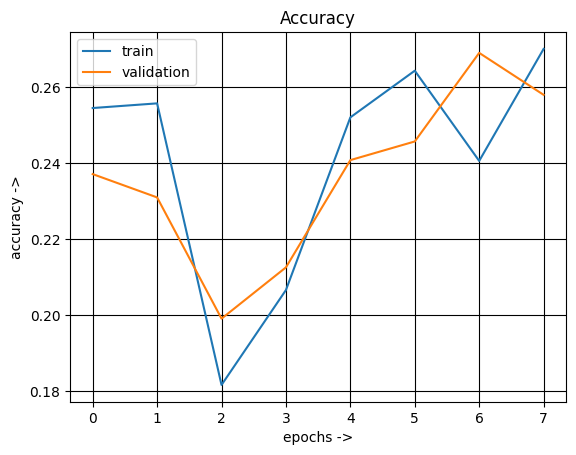

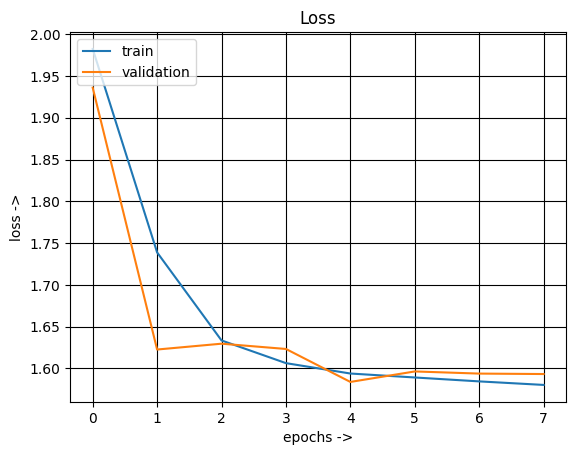

In [ ]:
from lib_util import plot
epochs= 20
with open('models/my_transformer/my_transformer_history.json', 'r') as f:
    history_dict = json.load(f)

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history_dict, ('categorical_accuracy', 'val_categorical_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/{config['name']}_{epochs}_acuracy')
plot.plot_hist(history_dict, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/{config['name']}_{epochs}_loss')

In [ ]:
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from lib_util import plot

# Test prediction
scores = transformer.evaluate(mel_test, lab_test)

y_pred = transformer.predict(mel_test)

epochs = 20

y_pred = np.argmax(y_pred, axis=1)

print(np.sum(y_pred==np.argmax(lab_test, axis=1))/y_pred.shape[0])

print(np.unique(y_pred))

class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(lab_test, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{config['name']}_{epochs}_test_conf_mat.png", name=config['name'], set_type='test')